In [ ]:
#importing the libraries that will be needed in the program. A library is essentially a collection of modules that can be called and used.
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
import datetime 
import plotly.express as px
from tabulate import tabulate
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import plotly.graph_objects as go

In [ ]:
test_data=pd.read_csv('/content/drive/My Drive/Kaggle Data/test.csv')
shop_data=pd.read_csv('/content/drive/My Drive/Kaggle Data/shops.csv')
sales_train=pd.read_csv('/content/drive/My Drive/Kaggle Data/sales_train.csv')
items_data=pd.read_csv('/content/drive/My Drive/Kaggle Data/items.csv')
items_cat=pd.read_csv('/content/drive/My Drive/Kaggle Data/item_categories.csv')

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Kaggle Data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('/content/drive/My Drive/Kaggle Data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('/content/drive/My Drive/Kaggle Data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('/content/drive/My Drive/Kaggle Data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('/content/drive/My Drive/Kaggle Data/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [ ]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [ ]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.000000,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.000000,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.000000,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.050049,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.000000,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-09-10,33,25,7460,299.000000,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.000000,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.000000,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [ ]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [ ]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


In [ ]:
train = train.query('item_price > 0')

In [ ]:
# Select only useful features.
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [ ]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [ ]:
train_monthly

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.000000,1532.857178,9,1.285714,7
1,0,2,2,5643,4775.209961,2387.604980,0,0.000000,2
2,0,2,5,5583,1188.300049,594.150024,2,1.000000,2
3,0,2,6,7893,5970.000000,1990.000000,3,1.000000,3
4,0,2,6,7894,1490.000000,1490.000000,1,1.000000,1
...,...,...,...,...,...,...,...,...,...
600154,33,59,75,5383,4390.000000,4390.000000,1,1.000000,1
600155,33,59,79,17717,8025.500000,802.549988,13,1.300000,10
600156,33,59,83,22087,357.000000,119.000000,6,2.000000,3
600157,33,59,83,22088,238.000000,119.000000,2,1.000000,2


In [ ]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [ ]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [ ]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [ ]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.0,16.500000,9.810709,0.0,8.00,16.5,25.00,33.00000
shop_id,6734448.0,31.642857,17.561894,2.0,16.00,34.5,47.00,59.00000
item_id,6734448.0,11041.890161,6210.744436,30.0,5385.25,11265.5,16068.25,22167.00000
item_category_id,6734448.0,3.786271,13.212956,0.0,0.00,0.0,0.00,83.00000
item_price,6734448.0,187.352417,2171.796631,0.0,0.00,0.0,0.00,515573.59375
mean_item_price,6734448.0,81.128105,531.164551,0.0,0.00,0.0,0.00,42990.00000
item_cnt,6734448.0,0.240223,3.456640,-4.0,0.00,0.0,0.00,2253.00000
mean_item_cnt,6734448.0,0.097299,0.612203,-2.0,0.00,0.0,0.00,1000.00000
transactions,6734448.0,0.181817,0.904735,0.0,0.00,0.0,0.00,31.00000


In [ ]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [ ]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

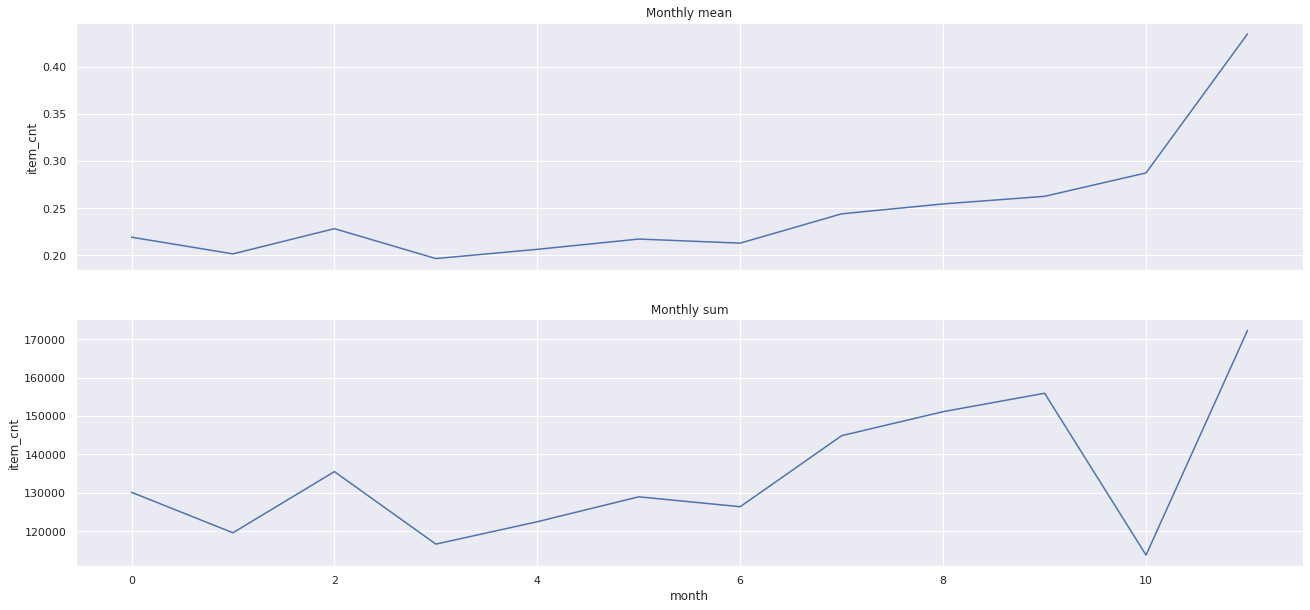

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

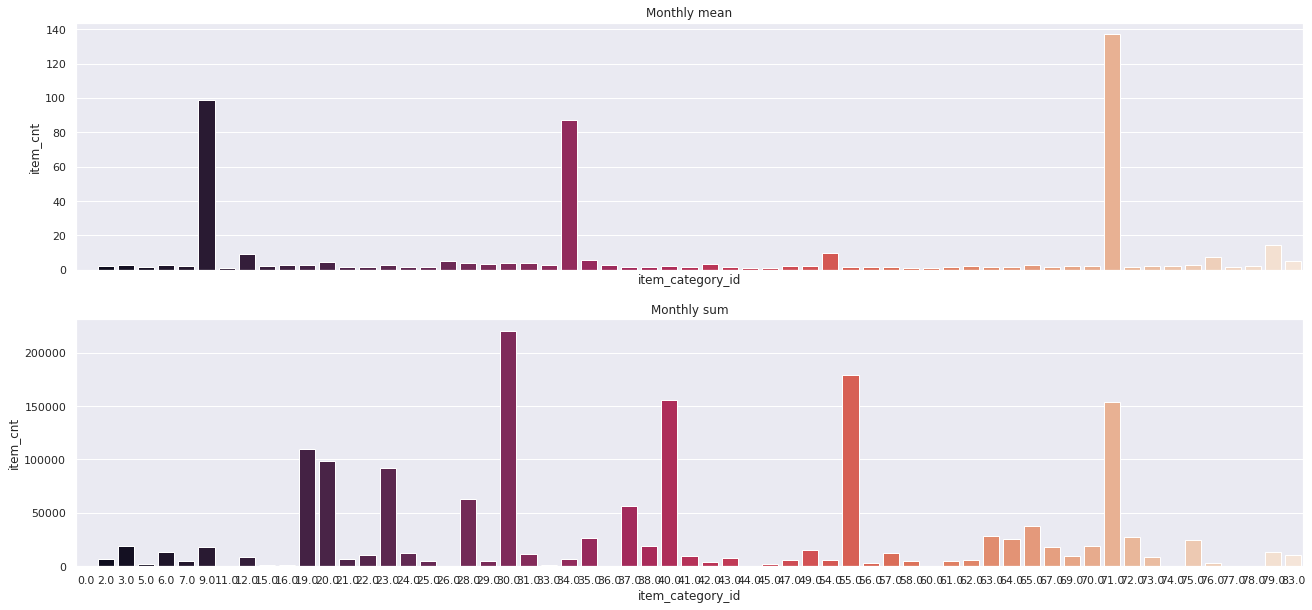

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

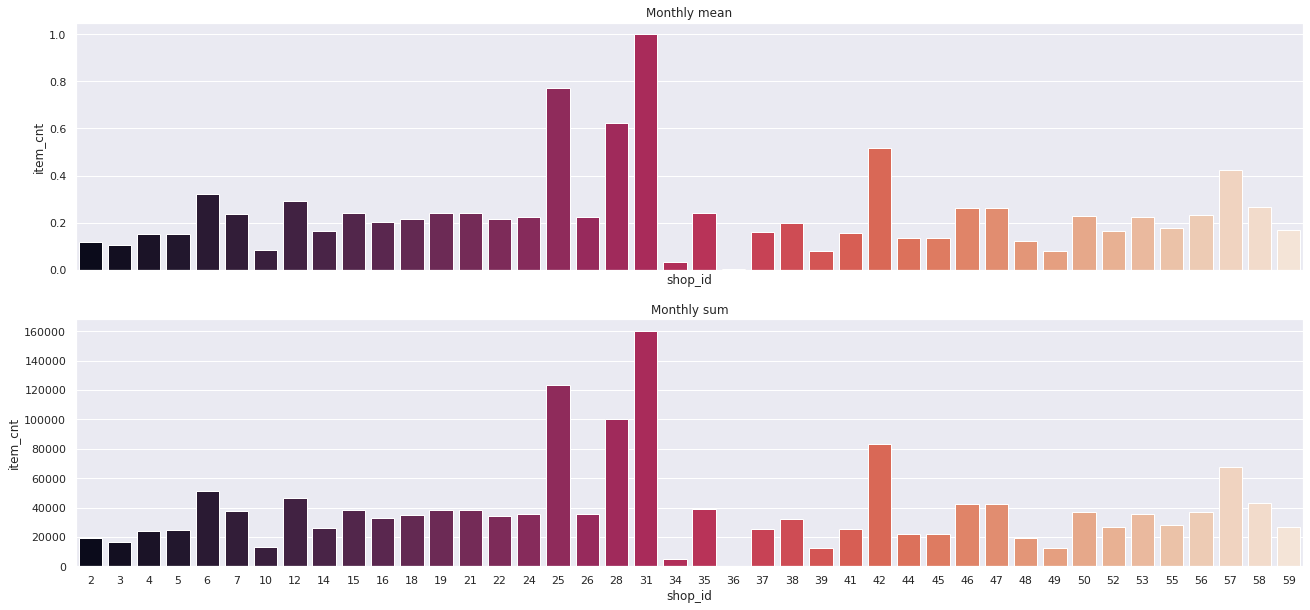

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

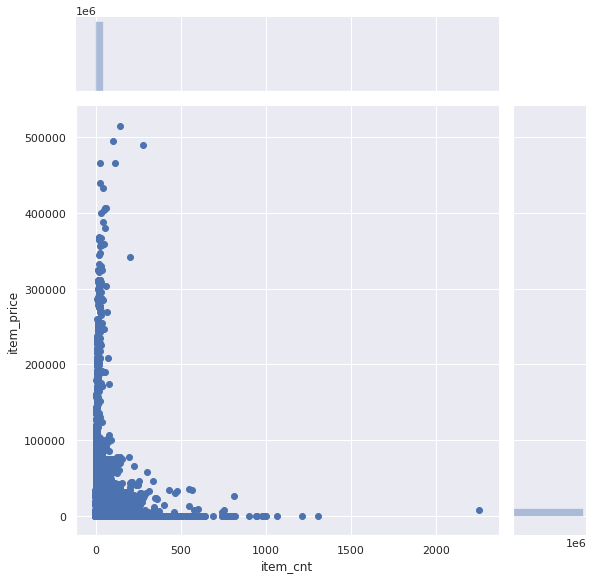

In [ ]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

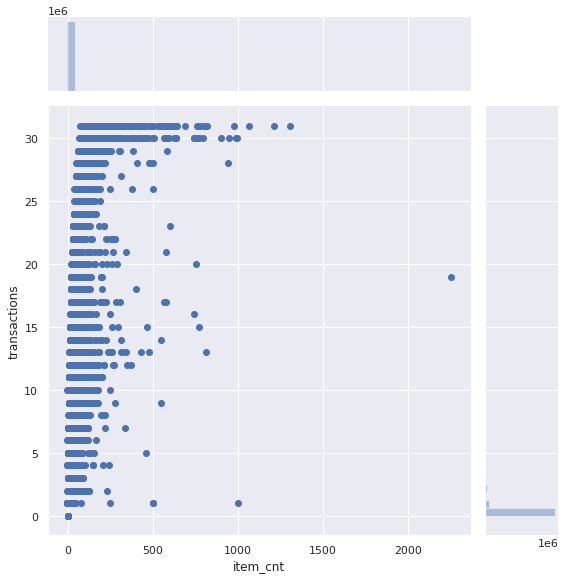

In [ ]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

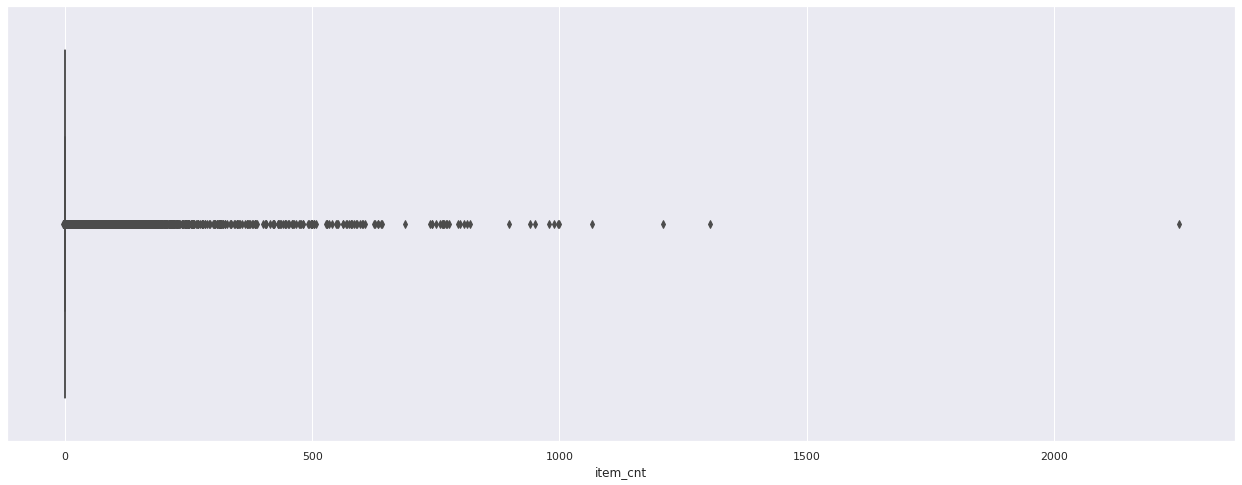

In [ ]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [ ]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

In [ ]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [ ]:
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0,1.0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0,0.0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0,1.0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0,2.0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9,NaN


In [ ]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [ ]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [ ]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [ ]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [ ]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [ ]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [ ]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


In [ ]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)
# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')


In [ ]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [ ]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [ ]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [ ]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
for dataset in sets:
    for item_id in dataset['item_id'].unique():
        for column in dataset.columns:
            item_median = dataset[(dataset['item_id'] == item_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [ ]:
X_train

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2.0,5572.0,2980.0,1490.0,2.0,1.0,2.0,2013.0,3.0,1490.0,0.0,18979.5,2980.0,15999.5,1.0,2.0,1.333333,0.577350,1.0,1.0,9.0,-2.25,0.097844,1.004766,0.84,0.135041,0.15732
1,2.0,5643.0,0.0,0.0,0.0,0.0,0.0,2013.0,3.0,0.0,0.0,35260.0,0.0,35260.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.097844,1.818702,1.84,0.135041,0.15732
2,2.0,5583.0,0.0,0.0,0.0,0.0,0.0,2013.0,3.0,0.0,0.0,5592.0,0.0,5592.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.097844,0.589524,0.04,0.135041,0.15732
3,2.0,7893.0,9350.0,1870.0,5.0,1.0,5.0,2013.0,3.0,1870.0,0.0,27950.0,9350.0,18600.0,1.0,5.0,2.666667,2.081666,1.0,2.0,3.0,-0.25,0.097844,3.038388,3.12,0.135041,0.15732
4,2.0,7894.0,0.0,0.0,0.0,0.0,0.0,2013.0,3.0,0.0,0.0,25880.0,0.0,25880.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.097844,3.670837,1.68,0.135041,0.15732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946780,36.0,9103.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,0.0,500.0,0.0,500.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732
4946781,36.0,9107.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,0.0,300.0,0.0,300.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732
4946782,36.0,5704.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,0.0,1750.0,0.0,1750.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732
4946783,36.0,12733.0,0.0,0.0,0.0,0.0,0.0,2015.0,3.0,0.0,0.0,2980.0,0.0,2980.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224950,0.15732


In [ ]:
Y_train

In [ ]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
      eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.354206
0:	learn: 0.8169916	test: 0.8683736	best: 0.8683736 (0)	total: 1.02s	remaining: 8m 28s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8067838309
bestIteration = 9

Shrink model to first 10 iterations.


In [ ]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [ ]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[20:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:08] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.942842	validation_1-rmse:0.92285
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.684505	validation_1-rmse:0.790693
Stopping. Best iteration:
[18]	validation_0-rmse:0.687606	validation_1-rmse:0.78818



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

In [ ]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [ ]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [ ]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [ ]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [ ]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [ ]:
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [ ]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [ ]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [ ]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.769232,0.699712,0.621826,0.598769,1.000000,0
1,0.873829,0.638456,0.557902,0.044736,0.777778,0
2,0.039220,0.103207,0.207674,0.044736,0.000000,0
3,1.198209,0.814267,0.947778,0.044736,0.111111,4
4,2.088991,1.585213,1.565252,1.455709,0.666667,1
5,0.722615,0.638456,0.457695,0.044736,0.111111,1
6,0.483697,0.434679,0.207674,0.044736,0.111111,0
7,0.039220,0.103207,0.059621,0.044736,0.000000,1
8,0.483697,0.376551,0.207674,0.044736,0.111111,0
9,1.639398,1.732688,1.130119,1.151160,2.888889,2


In [ ]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.473184,0.412190,0.948881,0.852372,0.888889
1,0.039220,0.079429,0.059621,0.058080,0.000000
2,0.558236,0.523621,0.854483,1.793033,1.111111
3,0.039220,0.079429,0.000363,0.058080,0.000000
4,0.039220,0.079429,0.059621,0.058080,0.000000


In [ ]:
meta_model = LinearRegression(n_jobs=-1)

In [ ]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7647244882048551


In [ ]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.803406
1,1,0.081317
2,2,1.240223
3,3,0.064157
4,4,0.081317
5,5,0.948317
6,6,1.215269
7,7,0.201977
8,8,1.962372
9,9,0.064157
